# Data Processing


*   Dog Breed Dataset



In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip training dataset
#!unzip -uq '/content/drive/My Drive/Colab Notebooks/297-98_hw2/train.zip'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
 #import all the packages


%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd

import time
from datetime import timedelta

import math
import os

import scipy.misc
from scipy.stats import itemfreq
from random import sample
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Image manipulation
import PIL.Image
from IPython.display import display

# Open a Zip File
from zipfile import ZipFile
from io import BytesIO

In [3]:
#Unzip Files


# We unzip the train and test zip file
archive_train = ZipFile('/content/drive/My Drive/CMPE_98/Dog_Breed_Identification/train.zip','r')

archive_test = ZipFile('/content/drive/My Drive/CMPE_98/Dog_Breed_Identification/test.zip', 'r')

# This line shows the 5 first image name of the train database
archive_train.namelist()[0:5]

# This line shows the number of images in the train database, noted that we must remove the 1st value (column header)
len(archive_train.namelist()[:]) - 1

10222

In [0]:
#Resize and normalize data#


# This function help to create  a pickle file gathering all the image from a zip folder
def DataBase_creator(archivezip, nwidth, nheight, save_name):
    # We choose the archive (zip file) + the new width and height for all the image which will be reshaped
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    # nwidth x nheight = number of features because images have nwidth x nheight pixels
    s = (len(archivezip.namelist()[:])-1, nwidth, nheight,3)
    allImage = np.zeros(s)
    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwidth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) # 255 = max of the value of a pixel
        allImage[i-1]=image
    
    # we save the newly created data base
    pickle.dump(allImage, open( save_name + '.p', "wb" ) )
    
    # Ending time.
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [5]:
# the new image size applied for all images and call the function above
image_resize = 60

DataBase_creator(archivezip = archive_train, nwidth = image_resize, nheight = image_resize , save_name = "/content/drive/My Drive/CMPE_98/Dog_Breed_Identification/train")


Time usage: 0:01:06


In [6]:
DataBase_creator(archivezip = archive_test, nwidth = image_resize, nheight = image_resize , save_name = "/content/drive/My Drive/CMPE_98/Dog_Breed_Identification/test")

Time usage: 0:01:44


In [0]:
# load TRAIN ###shape of the training data should be (10222, 60, 60, 3).

train = pickle.load( open( "/content/drive/My Drive/CMPE_98/Dog_Breed_Identification/train.p", "rb" ) )

train.shape

(10222, 60, 60, 3)

In [0]:
# load TEST ## shape of the training data should be (10222, 60, 60, 3)

test = pickle.load( open( "/content/drive/My Drive/CMPE_98/Dog_Breed_Identification/test.p", "rb" ) )

test.shape

(10357, 60, 60, 3)

In [0]:
#image_resize = 60
#nwidth = image_resize
#nheight = image_resize

# nwidth x nheight = number of features because images are nwidth x nheight pixels
#s = (len(df_train[‘breed’]), nwidth, nheight,3) 
#allImage = np.zeros(s)

#i = 0
#for f, breed in df_train.values:
#    image = PIL.Image.open('../input/train/{}.jpg'.format(f))
 #   image = image.resize((nwidth, nheight))
  #  image = np.array(image)
   # image = np.clip(image/255.0, 0.0, 1.0) # 255 = max of the value of a pixel
    #i += 1
    #allImage[i-1]=image

    #train = allImage 

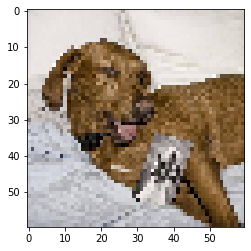

In [0]:
lum_img = train[100,:,:,:]
plt.imshow(lum_img)
plt.show()

In [0]:
#Check out labels file

labels_raw = pd.read_csv("/content/drive/My Drive/CMPE_98/Dog_Breed_Identification/labels.csv", header=0, sep=',', quotechar='"')
labels_raw.sample(5)

,id,breed
5925,95b04ef45b853922685ba6d257fc2f0c,japanese_spaniel
6889,ad111fe98c5802b0e61e23cd857ce509,basset
6278,9e7db8711f479dfa968b2297bee33104,shih-tzu
9932,f99cdde623294ec669ff9f2a31e17830,appenzeller
2967,49353ee8314c786682ae5cbe9f6f227a,miniature_poodle


In [0]:
#Extract the most represented breeds

Nber_of_breeds = 8

# Get the N most represented breeds
def main_breeds(labels_raw, Nber_breeds , all_breeds='TRUE'):
    labels_freq_pd = itemfreq(labels_raw["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]]
    
    if all_breeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:Nber_breeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labels_raw["breed"].as_matrix()
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)
    labels_filtered_index = np.where(labels_raw_np == main_labels)
    return labels_filtered_index

labels_filtered_index = main_breeds(labels_raw = labels_raw, Nber_breeds = Nber_of_breeds, all_breeds='FALSE')
labels_filtered = labels_raw.iloc[labels_filtered_index[0],:]
train_filtered = train[labels_filtered_index[0],:,:,:]
print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(Nber_of_breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


- Number of images remaining after selecting the 8 main breeds : (922,)
- The shape of train_filtered dataset is : (922, 60, 60, 3)


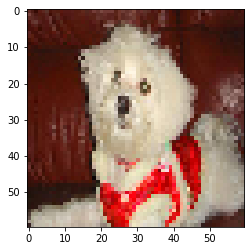

In [0]:
lum_img = train_filtered[1,:,:,:]
plt.imshow(lum_img)
plt.show()

In [0]:
#One-Hot Labels

In [0]:
# We select the labels from the N main breeds
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


(922, 1)

In [0]:
# Function to create one-hot labels
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [0]:
labels_name, labels_bin = matrix_Bin(labels = labels)
labels_bin[0:9]

Nber SubVariables 8
Shape : (922, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  app.launch_new_instance()


array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.]])

In [0]:
#Quick check on labels#

In [0]:
for breed in range(len(labels_name)):
   print('Breed {0} : {1}'.format(breed,labels_name[breed]))

Breed 0 : afghan_hound
Breed 1 : bernese_mountain_dog
Breed 2 : entlebucher
Breed 3 : great_pyrenees
Breed 4 : maltese_dog
Breed 5 : pomeranian
Breed 6 : scottish_deerhound
Breed 7 : shih-tzu


In [0]:
labels_cls = np.argmax(labels_bin, axis=1)
labels[0:9]

array([['scottish_deerhound'],
       ['maltese_dog'],
       ['shih-tzu'],
       ['scottish_deerhound'],
       ['entlebucher'],
       ['entlebucher'],
       ['maltese_dog'],
       ['bernese_mountain_dog'],
       ['entlebucher']], dtype=object)

Convolutional Neural Networks

In [0]:
#Creation of a Train and Validation Data

In [0]:
num_validation = 0.30
X_train, X_validation, y_train, y_validation = train_test_split(train_filtered, labels_bin, test_size=num_validation, random_state=6)

In [0]:
#Creation of a Train and Test Data


In [0]:

def train_test_creation(x, data, toPred): 
  indices = sample(range(data.shape[0]),int(x * data.shape[0])) 
  indices = np.sort(indices, axis=None) 
  
  index = np.arange(data.shape[0]) 
  reverse_index = np.delete(index, indices,0)
  
  train_toUse = data[indices]
  train_toPred = toPred[indices]
  test_toUse = data[reverse_index]
  test_toPred = toPred[reverse_index]

  return train_toUse, train_toPred, test_toUse, test_toPred

df_train_toUse, df_train_toPred, df_test_toUse, df_test_toPred = train_test_creation(0.7, train_filtered, labels_bin)

df_validation_toPred_cls = np.argmax(y_validation, axis=1)
df_validation_toPred_cls[0:9]

array([5, 1, 5, 6, 7, 2, 5, 1, 1])

In [0]:
#CNN with TensorFlow — Defining Layers

In [0]:
# Our images are 100 pixels in each dimension.
img_size = image_resize

# Number of colour channels for the images: 3
num_channels = 3

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Image Shape
img_shape = (img_size, img_size, num_channels)

# Number of classes : 5 breeds
num_classes = Nber_of_breeds

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    #outputs random value from a truncated normal distribution

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
    #outputs the constant value 0.05

In [0]:
#convolution layer.

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True,
                   use_dropout=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_conv)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [0]:
# flatten layer.


def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [0]:
#fully-connected layer.

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True,
                 use_dropout=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_fc)
        
    return layer

In [0]:
#CNN with TensorFlow — Set up placeholder tensor

In [0]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels]) #-1 put everything as 1 array
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
keep_prob_fc=tf.placeholder(tf.float32)
keep_prob_conv=tf.placeholder(tf.float32)

In [0]:
#CNN with TensorFlow — Design the layer

In [0]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 32 of these filters.


# Convolutional Layer 2.
filter_size2 = 4          # Convolution filters are 4 x 4 pixels.
num_filters2 = 64      # There are 64 of these filters.


# Convolutional Layer 3.
filter_size3 = 3          # Convolution filters are 3 x 3 pixels.
num_filters3 = 128      # There are 128 of these filters.


# Fully-connected layer.
fc_size = 500 

layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True,
                   use_dropout=True)

layer_flat, num_features = flatten_layer(layer_conv3)

#Train
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         use_dropout=True)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False,
                         use_dropout=False)

#Prediction
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#CNN with TensorFlow — Cross-entropy loss

In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
#CNN with TensorFlow — Train the model

In [0]:
session = tf.Session()
def init_variables():
   session.run(tf.global_variables_initializer())

In [0]:
batch_size = 50

#function next_batch
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]


    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [0]:
def optimize(num_iterations, X):
    global total_iterations
    
    start_time = time.time()
    
    #array to plot
    losses = {'train':[], 'validation':[]}
    
    for i in range(num_iterations):
            total_iterations += 1
            # Get a batch of training examples.
            # x_batch now holds a batch of images and
            # y_true_batch are the true labels for those images.
            x_batch, y_true_batch = next_batch(batch_size, X_train, y_train)


            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch,
                               keep_prob_conv : 0.3,
                               keep_prob_fc : 0.4}
            feed_dict_validation = {x: X_validation,
                               y_true: y_validation,
                               keep_prob_conv : 1,
                               keep_prob_fc : 1}
            
            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)
            
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)
            acc_validation = session.run(accuracy, feed_dict=feed_dict_validation)
            losses['train'].append(acc_train)
            losses['validation'].append(acc_validation)
            
            # Print status every X iterations.
            if (total_iterations % X == 0) or (i ==(num_iterations -1)):
            # Calculate the accuracy on the training-set.
                                
                msg = "Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}"
                print(msg.format(total_iterations, acc_train, acc_validation))
                
    
    # Ending time.
    end_time = time.time()


    # Difference between start and end-times.
    time_dif = end_time - start_time


    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()

Iteration:    250, Training Accuracy:  40.0%, Validation Accuracy:  34.7%
Iteration:    500, Training Accuracy:  32.0%, Validation Accuracy:  38.6%
Iteration:    750, Training Accuracy:  72.0%, Validation Accuracy:  39.7%
Iteration:   1000, Training Accuracy:  56.0%, Validation Accuracy:  41.9%
Iteration:   1250, Training Accuracy:  68.0%, Validation Accuracy:  41.9%
Iteration:   1500, Training Accuracy:  68.0%, Validation Accuracy:  41.2%
Iteration:   1750, Training Accuracy:  80.0%, Validation Accuracy:  42.2%
Iteration:   2000, Training Accuracy:  88.0%, Validation Accuracy:  40.4%
Iteration:   2250, Training Accuracy:  94.0%, Validation Accuracy:  41.2%
Iteration:   2500, Training Accuracy:  94.0%, Validation Accuracy:  41.2%
Iteration:   2750, Training Accuracy:  94.0%, Validation Accuracy:  39.4%
Iteration:   3000, Training Accuracy: 100.0%, Validation Accuracy:  39.7%
Iteration:   3250, Training Accuracy:  96.0%, Validation Accuracy:  40.4%
Iteration:   3500, Training Accuracy: 

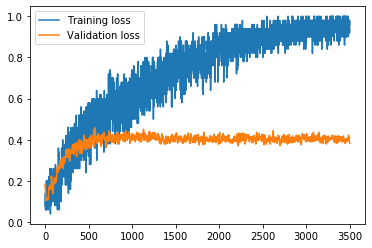

In [0]:
init_variables()
total_iterations = 0
optimize(num_iterations=3500, X=250)

In [0]:
#CNN with TensorFlow — Results/

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 12
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(4, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)


    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')


        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])


        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
def plot_confusion_matrix(data_pred_cls,data_predicted_cls):
    # This is called from print_test_accuracy() below.


    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
  
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=data_pred_cls,
                          y_pred=data_predicted_cls)


    # Print the confusion matrix as text.
    print(cm)


    # Plot the confusion matrix as an image.
    plt.matshow(cm)


    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')


    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
def plot_confusion_matrix(data_pred_cls,data_predicted_cls):
    # This is called from print_test_accuracy() below.


    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
  
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=data_pred_cls,
                          y_pred=data_predicted_cls)


    # Print the confusion matrix as text.
    print(cm)


    # Plot the confusion matrix as an image.
    plt.matshow(cm)


    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')


    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

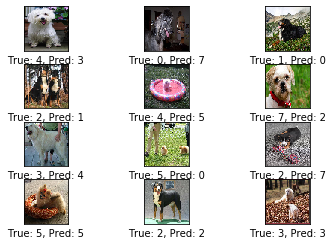

In [0]:
feed_dict_validation = {x: X_validation, y_true: y_validation, keep_prob_conv : 1, keep_prob_fc : 1}
df_validation_Predicted_cls = session.run(y_pred_cls, feed_dict=feed_dict_validation)
plot_images(images=X_validation[50:62], cls_true=df_validation_toPred_cls[50:62], cls_pred=df_validation_Predicted_cls [50:62])

In [0]:
i = 63
print(("True : {0} / {1}").format(df_validation_toPred_cls[i], labels_name[df_validation_toPred_cls[i]]))
print(("Pred : {0} / {1}").format(df_validation_Predicted_cls[i], labels_name[df_validation_Predicted_cls[i]]))
lum = X_validation[i,:,:,:]
plt.show()

True : 7 / shih-tzu
Pred : 7 / shih-tzu


[[ 6  2  4  3  2  5  6  3]
 [ 1 17 12  1  0  0  2  6]
 [ 0  7 23  1  0  0  3  2]
 [ 1  3  1 11  5  6  4  3]
 [ 1  0  0  7  9 14  1  2]
 [ 3  1  0  3  2 18  1  1]
 [ 4  2  2  8  1  1 15  1]
 [ 2  2  2  7  5 11  4  7]]


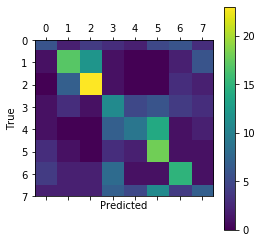

In [0]:
plot_confusion_matrix(df_validation_toPred_cls,df_validation_Predicted_cls)